In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [15]:
!ls '/content/drive/Team Drives/2018 Pathology Project/Data'

 Ayushi  'Data Science Bowl 2018'   Gian   ICPR12   To_Review   TUPAC16


In [4]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, Dropout
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 19
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [0]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

TRAIN_PATH = '/content/drive/Team Drives/2018 Pathology Project/Data/Data Science Bowl 2018/stage1_train/'
TEST_PATH = '/content/drive/Team Drives/2018 Pathology Project/Data/Data Science Bowl 2018/stage1_test/'

In [0]:
train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)

train_images = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
test_images = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

(256, 256, 3)


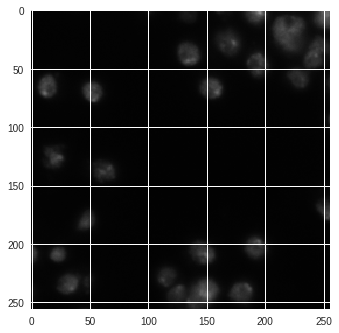

In [15]:
img=imread(TRAIN_PATH + "/" + train_ids[0] + '/images/' + train_ids[0] + '.png')[:,:,:IMG_CHANNELS]
print(img.shape)
plt.imshow(img)

In [24]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img



  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 1/670 [00:00<02:02,  5.47it/s]

  0%|          | 2/670 [00:00<02:01,  5.48it/s]

  0%|          | 3/670 [00:00<01:57,  5.67it/s]

  1%|          | 4/670 [00:00<02:36,  4.26it/s]

  1%|          | 5/670 [00:01<02:23,  4.65it/s]

  1%|          | 6/670 [00:01<02:03,  5.39it/s]

  1%|          | 7/670 [00:01<02:38,  4.18it/s]

  1%|          | 8/670 [00:01<02:27,  4.48it/s]

  1%|▏         | 10/670 [00:02<02:28,  4.43it/s]

  2%|▏         | 11/670 [00:02<02:08,  5.12it/s]

  2%|▏         | 12/670 [00:02<01:57,  5.61it/s]

  2%|▏         | 13/670 [00:03<03:53,  2.81it/s]

  2%|▏         | 14/670 [00:03<03:18,  3.30it/s]

  2%|▏         | 15/670 [00:03<03:57,  2.76it/s]

  2%|▏         | 16/670 [00:04<03:29,  3.12it/s]

  3%|▎         | 18/670 [00:04<02:50,  3.83it/s]

  3%|▎         | 19/670 [00:04<02:33,  4.23it/s]

  3%|▎         | 21/670 [00:04<02:06,  5.14it/s]

  3%|▎         | 23/670 [00:07<05:41,  1.89it/s]

  4%|▎         

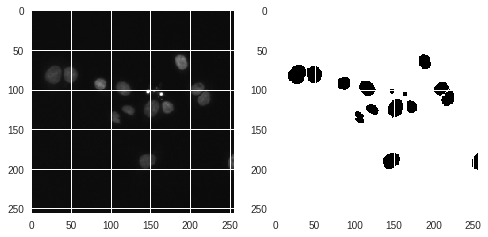

In [25]:
plt.subplot(1,2,1)
plt.imshow(X_train[5])
plt.subplot(1,2,2)
plt.imshow(np.squeeze(Y_train[5]))

In [30]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 448         lamb

In [31]:
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))



65/65 [==============================] - 1s 13ms/step


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


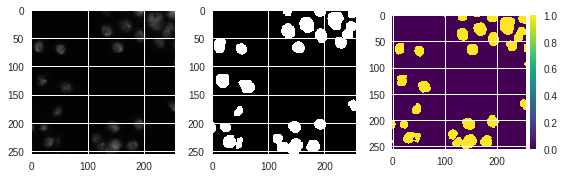

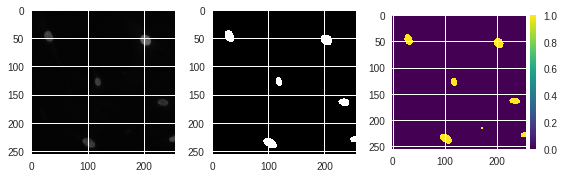

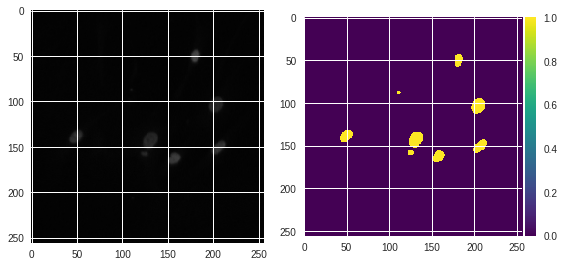

In [34]:
plt.subplot(1,3,1)
imshow(X_train[0])
plt.subplot(1,3,2)
imshow(np.squeeze(Y_train[0]))
plt.subplot(1,3,3)
imshow(np.squeeze(preds_train_t[0]))
plt.show()

plt.subplot(1,3,1)
imshow(X_train[int(X_train.shape[0]*0.9):][0])
plt.subplot(1,3,2)
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][0]))
plt.subplot(1,3,3)
imshow(np.squeeze(preds_val_t[0]))
plt.show()

plt.subplot(1,2,1)
imshow(X_test[0])
plt.subplot(1,2,2)
imshow(np.squeeze(preds_test_t[0]))
plt.show()



Implementing Object Detection directly on original images


In [6]:
IMG_WIDTH = 384
IMG_HEIGHT = 384
IMG_CHANNELS = 3

train_images = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
test_images = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

# Resize train images.
print('resize train images... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + "/" + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    train_images[n] = img
    
# Get and resize test images
sizes_test = []
print('resize test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + "/" + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    test_images[n] = img

print('Done!')



resize train images... 


100%|██████████| 670/670 [08:30<00:00,  1.25it/s]

resize test images ... 



100%|██████████| 65/65 [00:44<00:00,  1.51it/s]

Done!


In [7]:
def store_bounding_boxes(img, train_id, mask_id, rotby_90):
    ret, thresh = cv2.threshold(img, 127, 255, 0)
    contours = cv2.findContours(thresh.astype(np.uint8), 1, 2)
    cnt = contours[0]
        
    x, y, w, h = cv2.boundingRect(cnt)    
    
    x = x * (IMG_WIDTH/img.shape[1])
    w = w * (IMG_WIDTH/img.shape[1])
    y = y * (IMG_WIDTH/img.shape[0])
    h = h * (IMG_WIDTH/img.shape[0])
    
    if(x > IMG_WIDTH-1):
        x = IMG_WIDTH-1
    if(y > IMG_HEIGHT-1):
        y = IMG_HEIGHT-1
    if(x+w > IMG_WIDTH-1):
        w = IMG_WIDTH-1 - x
    if(y+h > IMG_HEIGHT-1):
        h = IMG_HEIGHT-1 - y
        
    bbdict = { "train_id": train_id, "mask_id": mask_id, "rotby_90": rotby_90, "x": x, "y": y, "w": w, "h": h}
    return bbdict
  
path_bboxes_csv = "/content/drive/Team Drives/2018 Pathology Project/Data/Data Science Bowl 2018/bboxes.csv"
if not os.path.isfile(path_bboxes_csv):
    bboxes = pd.DataFrame(columns=["train_id", "mask_id", "rotby_90", "x", "y", "w", "h"])
    row_count = 1
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = TRAIN_PATH + "/" + id_
        for mask_id, mask_file in enumerate(next(os.walk(path + '/masks/'))[2]):
            mask_ = imread(path + '/masks/' + mask_file)
            for r in range(4):
                bboxes.loc[row_count] = store_bounding_boxes(np.rot90(mask_, r), id_, mask_id, r)
                row_count += 1
    bboxes.to_csv(path_bboxes_csv, index=False)
else:
    bboxes = pd.read_csv(path_bboxes_csv)
    
GRID_DIM = 12
GRID_PIX = IMG_WIDTH//GRID_DIM
BATCH_SIZE = 14

train_ids_df = pd.DataFrame(columns=["idx", "id_"])
cnt = 0
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    train_ids_df.loc[cnt] = { "idx": n, "id_": id_}
    cnt += 1

train_ids_df = train_ids_df.set_index(['idx'])

bboxes['grid_row'] = bboxes['y']//GRID_PIX
bboxes['grid_column'] = bboxes['x']//GRID_PIX

bboxes['grid_center_x'] = bboxes['grid_column'] * GRID_PIX + GRID_PIX/2
bboxes['grid_center_y'] = bboxes['grid_row'] * GRID_PIX + GRID_PIX/2

bboxes['box_center_x'] = bboxes.x + bboxes['w']/2
bboxes['box_center_y'] = bboxes.y + bboxes['h']/2

bboxes['new_x'] = (bboxes.box_center_x - bboxes.grid_center_x)/(IMG_WIDTH)
bboxes['new_y'] = (bboxes.box_center_y - bboxes.grid_center_y)/(IMG_HEIGHT)

bboxes['new_w'] = np.sqrt(bboxes.w/(IMG_WIDTH))
bboxes['new_h'] = np.sqrt(bboxes.h/(IMG_WIDTH))

bboxes['confidence'] = 1

bboxes['box_area'] = bboxes.new_w*bboxes.new_h




100%|██████████| 670/670 [00:01<00:00, 365.21it/s]


In [0]:
mask_count = 1
#Set maximum bounding boxes allowed per grid cell
MAX_BB_CNT = 2

def get_grid_info(tr_id, rotby_90):
    df = bboxes.loc[(bboxes.train_id == tr_id) & (bboxes.rotby_90 == rotby_90), 'grid_row':'box_area']
    df.drop(['grid_center_x', 'grid_center_y','box_center_x', 'box_center_y',], axis = 1, inplace=True)
    df = df.sort_values(['grid_column', 'grid_row', 'box_area'], ascending=False)
    #print(len(df))
    global mask_count
    mask_count += len(df)
    label_info = np.zeros(shape=(GRID_DIM, GRID_DIM, MAX_BB_CNT, 5),  dtype=np.float32) + 0.000001
    
    for ind, row in df.iterrows():
        i = int(row[0])
        j = int(row[1])
        for b in range(MAX_BB_CNT):
            if(label_info[i, j, b][4] != 1.0):
                label_info[i, j, b] = np.array(row[2:7])
                break
    return label_info

def get_labels(counts, rotations):
  grid_info = np.zeros(shape=(BATCH_SIZE, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5), dtype=np.float32)
  for i, c in enumerate(counts):
      tr_id = train_ids_df.loc[c, 'id_']
      grid_info[i] = get_grid_info(tr_id, rotations[i])
  grid_info = np.reshape(grid_info, newshape=[BATCH_SIZE, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])
  return grid_info

def get_images(counts, rotations):
    images = np.zeros(shape=(BATCH_SIZE, IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=np.uint8)
    for i, c in enumerate(counts):
        images[i] = np.rot90(train_images[c], rotations[i])
    return images

def next_batch():
    rotations = []
    rand_counts = []
    for i in range(BATCH_SIZE):
        rotations.append(random.randint(0, 3))
        rand_counts.append(random.randint(0, 669))
    return get_images(rand_counts, rotations), get_labels(rand_counts, rotations)

tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, IMG_WIDTH, IMG_HEIGHT, 3])
Y_ = tf.placeholder(tf.float32, [None, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])
lr = tf.placeholder(tf.float32)

def process_logits(logits, name=None):
    net = tf.reshape(logits, [-1, GRID_DIM*1, GRID_DIM*1, MAX_BB_CNT*5*16, 1])
    net = tf.layers.average_pooling3d(net, [1, 1, 16], [1, 1, 16], padding="valid")

    net = tf.reshape(net, [-1, GRID_DIM*GRID_DIM*MAX_BB_CNT, 5]) #GRID_DIM = 12
    net = tf.transpose(net, [1, 2, 0])        

    logits_tensor = tf.map_fn(lambda x:
                            tf.stack([
                                tf.tanh(x[0]),
                                tf.tanh(x[1]),
                                tf.sqrt(tf.sigmoid(x[2])),
                                tf.sqrt(tf.sigmoid(x[3])),
                                tf.sigmoid(x[4])
                            ]), net)

    logits_tensor = tf.transpose(logits_tensor, [2, 0, 1])
    logits_tensor = tf.reshape(logits_tensor, [-1, GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])

    return logits_tensor

def normalize_yolo_loss(processed_logits, lambda_coords, lambda_noobj):
    yolo_loss = tf.reduce_sum(tf.squared_difference(labels, processed_logits), axis=0)
    yolo_loss = tf.reduce_sum(yolo_loss, axis=0)
    yolo_loss = tf.reduce_sum(yolo_loss, axis=0)
    yolo_loss = tf.reduce_sum(yolo_loss, axis=0)

    yolo_loss = tf.stack([tf.multiply(lambda_coords, yolo_loss[0]), 
                          tf.multiply(lambda_coords, yolo_loss[1]),
                          yolo_loss[2],
                          yolo_loss[3],
                          tf.multiply(lambda_noobj,yolo_loss[4])])
    yolo_loss = tf.reduce_sum(yolo_loss)

    return  yolo_loss

def l_relu(features):
    return tf.nn.leaky_relu(features, 0.1)



In [9]:
# Below code need optimization may be by using Variable Scope.
def squeeze_module(x, dim, idx):
    name = 'conv_' + idx + '_sq'
    return tf.layers.conv2d(x, filters=dim, kernel_size=1, strides=1, padding="same", 
                           activation=l_relu, name=name)

def expand_module(x, dim, idx):
    name = 'conv_' + idx + '_ex_' + '0'
    net1 = tf.layers.conv2d(x, filters=dim, kernel_size=1, strides=1, padding="same", 
                           activation=l_relu, name=name)
    name = 'conv_' + idx + '_ex_' + '1'
    net2 = tf.layers.conv2d(x, filters=dim, kernel_size=3, strides=1, padding="same", 
                           activation=l_relu, name=name) 
    return tf.concat([net1, net2], 3)

def fire_module(input_tensor, squeeze_dim, expand_dim, idx):
    net = squeeze_module(input_tensor, squeeze_dim, idx)
    net = expand_module(net, expand_dim, idx)
    return net

# Below code need optimization may be by using Variable Scope.

net = tf.layers.conv2d(X, filters=32, kernel_size=1, strides=1, padding="same", 
                       activation=l_relu, name='conv0') #384 

net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same") #192

net = fire_module(net, 32, 64, '0')
net = fire_module(net, 32, 64, '1')
net = fire_module(net, 32, 64, '2')

net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same") #96


net = fire_module(net, 64, 96, '3')
net = fire_module(net, 64, 96, '4')
net = fire_module(net, 64, 96, '5')


net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same") #48

net = fire_module(net, 128, 160, '6')
net = fire_module(net, 128, 160, '7') 
net = fire_module(net, 128, 128, '8')


net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same") #24

net = fire_module(net, 256, 512, '9')
net = fire_module(net, 256, 512, '10')
net = fire_module(net, 256, 512, '11')

net = tf.layers.max_pooling2d(net, pool_size=2, strides=2, padding="same") #12

net = fire_module(net, 512, 1024, '12')
net = fire_module(net, 512, 1024, '13')
net = fire_module(net, 512, 1024, '14')

logits = tf.layers.conv2d(net, filters=MAX_BB_CNT*5*16, kernel_size=1, strides=1, padding="same",
                       activation=None, name='conv40') #12

processed_logits = process_logits(logits)

labels = Y_

lambda_coords = tf.constant(5.0)
lambda_noobj = tf.constant(0.5)

yolo_loss = normalize_yolo_loss(processed_logits, lambda_coords, lambda_noobj)

train_op = tf.train.AdamOptimizer(lr).minimize(yolo_loss)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

batch_count = 0
display_count = 1
global mask_count



Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.average_pooling3d instead.
Instructions for updating:
Use tf.cast instead.


In [10]:
for i in range(33000):
    batch_X, batch_Y = next_batch()
    batch_count += 1
    train_loss, _ = sess.run([yolo_loss, train_op], {X: batch_X, Y_: batch_Y, lr: 0.0001})

    if(i % 100 == 0):
        print(str(display_count) + " training loss(" + str(mask_count) + "): " + str(train_loss))
        display_count +=1
    mask_count = 0
print("Done!")

test_image_id = 14
result = sess.run([processed_logits], {X: np.reshape(test_images[test_image_id], [1, 384, 384, 3])})

1 training loss(951): 4252.5234
2 training loss(500): nan
3 training loss(370): nan
4 training loss(477): nan
5 training loss(843): nan
6 training loss(374): nan
7 training loss(416): nan


KeyboardInterrupt: ignored

In [16]:
test_image_id = 33
saver = tf.train.Saver()
with tf.Session() as sess:
  saver.restore(sess, "/content/drive/My Drive/pretrained/model.ckpt")
  result = sess.run([processed_logits], {X: np.reshape(test_images[test_image_id], [1, 384, 384, 3])})

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/pretrained/model.ckpt


(1, 12, 12, 2, 5)


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


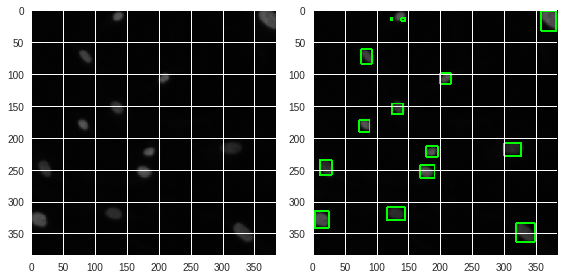

In [19]:
import math
import cv2
boxes = result[0]
print(boxes.shape)
boxes = np.reshape(boxes, newshape=[GRID_DIM, GRID_DIM, MAX_BB_CNT, 5])
bbs = []

for i in range(GRID_DIM):
    for j in range(GRID_DIM):
        for b in range(MAX_BB_CNT):
            if(boxes[i][j][b][4]> 0.1):
                grid_center_x = ((j+0)*GRID_PIX + GRID_PIX/2)
                grid_center_y = ((i+0)*GRID_PIX + GRID_PIX/2)
                
                new_box_center_x = boxes[i][j][b][0] * IMG_WIDTH + grid_center_x
                new_box_center_y = boxes[i][j][b][1] * IMG_HEIGHT + grid_center_y

                new_w = np.square(boxes[i][j][b][2]) * IMG_WIDTH
                new_h = np.square(boxes[i][j][b][3]) * IMG_HEIGHT
                
                x1 = new_box_center_x - new_w/2
                y1 = new_box_center_y - new_h/2

                x2 = new_box_center_x + new_w/2
                y2 = new_box_center_y + new_h/2

                bbs.append((math.floor(x1), math.floor(y1), math.ceil(x2), math.ceil(y2)))
                
img = test_images[test_image_id]
f, axs = plt.subplots(1,2)
axs[0].imshow(img)

imshow(img)
for i, b in enumerate(bbs):
    cv2.rectangle(img,(b[0], b[1]),(b[2], b[3]),(0,255,0),2)

axs[1].imshow(img)
